# <center>  Python for biologists
    
## Homework 12, Data analysis



### Правила

- Не создавайте доп. веток в репозитории, не копируйте ноутбук.
- Пишите код только там, где это от вас требуется (`# YOUR CODE HERE`)
- Используйте разобранный нами функционал, решения через циклы, `Counter` и т.п. засчитываться не будут.
- Перед отправкой проверьте что ваш ноутбук работает (юпитер-ноутбук). Нажмите на панели сверху `Kernel` -> `Restart Kernel and Run All Cells...`. Проверье что нет ошибок.
    

#### Погнали!

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from IPython.display import display

# здесь любые импорты которые вам еще понадобятся (только здесь)

# Продвинутая работа с одним дата-фреймом  </br> на примере биомедицинских данных

Мы будем работать с фармакокинетическим Варифариновым датасетом `warfarin.csv` (конкретный пример взят [отсюда](https://insightrx.github.io/PKPDsim/reference/pkdata.html?q=pkdata), но почитать можно [тут](https://dataset.lixoft.com/data-set-examples/warfarin-data-set/) и [тут](https://ascpt.onlinelibrary.wiley.com/doi/10.1038/clpt.2010.37/)). 

Датасет содержит следующие колонки:
- `ID` - Идентификатор пациента
- `Time` - Время внесения записи
- `WT` - Вес пациента
- `AGE` - Возраст пациента
- `SEX` - Пол пациента
- `CRCL` - Клиренс креатинина пациента (показатель работоспособности почек)
- `EVID` - Event ID - флаг который обозначает тип события: 1 - администрирование (введение) дозы варфарина, 0 - запись концентрации варфарина в крови
- `AMT` - Amount, Доза варфарина которая была дана пациенту
- `DV` - Зависимая переменная в анализе, концентрация варфарина в крови

Соотвественно про данные история такая, что не может быть одновременной записи DV и AMT. Мы либо даем дозу, либо измеряем концентрацию - не одновременно. Это и обозначает флаг EVID.  Поэтому если в DV стоит 0 - это не значит что концентрация 0, скорее всего эта запись отмечена флагом EVID 1, то мы и не знаем концентрацию, мы её не измеряли. 




In [2]:
warfarin = pd.read_csv('data/warfarin.csv', sep='\t')

### Задание 1 📈 

Сколько в среднем имеется записей на пациента? 


*(0.5 балла)*

In [3]:
result = warfarin.ID.count()/warfarin.ID.nunique()

In [4]:
assert result == 13.0

### Задание 2 📈 

Выведите средний возраст всех пациентов. 


*(0.5 балла)*

In [5]:
result = result = warfarin.AGE.mean()

In [6]:
assert np.isclose(result, 53.0883, atol=1e-3)

### Задание 3 📈 

Выведите в виде списка имена колонок, где у каждого пациента значения не меняются


*(0.5 балла)*

In [7]:
result = result = []
for column in warfarin.columns:
    if column == 'ID':
        continue
    
    is_unique_for_all_IDs = True

    for ID in warfarin['ID'].unique():
        if warfarin[warfarin['ID'] == ID][column].nunique() != 1:
            is_unique_for_all_IDs = False
            break

    if is_unique_for_all_IDs:
        result.append(column)

print(result)

['WT', 'CRCL', 'AGE', 'SEX']


In [8]:
assert result == ['WT', 'CRCL', 'AGE', 'SEX']

### Задание 4 📈 

Постройте [Spaghetti plot](https://en.wikipedia.org/wiki/Spaghetti_plot) DV vs TIME по каждому ID, отметьте вертикальными линиями моменты времени когда вводилась доза. Референсный график приеден в файле `spaghetti_plot.png`.  Обратите внимание, что на референсе `DV` не "проваливается" до 0. Почему?

Легенду по цветами выводить не надо :)

*(1.5 балла)*

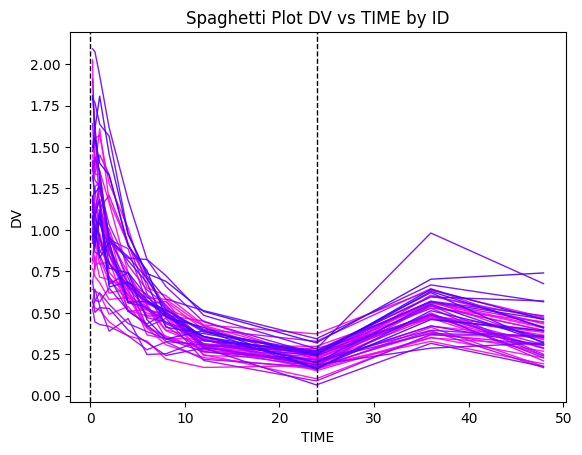

In [9]:
warfarin = warfarin[(warfarin['TIME'] != 0) & (warfarin['DV'] != 0)]
plt.style.use('default')
palette = plt.get_cmap('gist_rainbow_r')
num = 0
for ID, group in warfarin.groupby('ID'):
    num += 1
    plt.plot(group['TIME'], group['DV'], marker='', color=palette(num), linewidth=1, alpha=0.9)
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)
plt.axvline(x=24, color='black', linestyle='dashed', linewidth=1)

plt.title("Spaghetti Plot DV vs TIME by ID", loc='center', fontsize=12, fontweight=0, color='black')
plt.xlabel("TIME")
plt.ylabel("DV")
plt.yticks(np.arange(0, plt.ylim()[1], 0.25))

plt.show()

> Ну а далее ученые-фармакометрики строят по этим графикам математические модели (нелинейные) чтобы уметь описывать фармакокинетический профиль концентрации лекарства в крови, учитывать влияние пола / веса / генотипа / ... человека, и в конце-концов, предсказывать ту самую оптимальную дозу для конкретного пациента. Таргетная терапия! Но это уже совсем другая история.

# Продвинутая работа с несколькими дата-фреймами  </br> на примере биоинформатических данных

Мы будем работать со следующими омиксными данными:
- RNA-seq малых РНК из нейронов здорового человека и пациента с некоторым нейродегенеративным заболеванием
- ChIP-seq'и за белки 'CTCF' и 'SMC3' (они в том числе отвечают за структуру хроматина и экспрессию генов)



### Задание 6 📈 Подготовка данных


##### 1) Прочитайте данные в 3 датафрема `ctcf`, `smc3` и `rnaseq`. Для этого вам понадобится:
- Понять названия колонок (про форматы данных можно почитать [тут](https://genome.ucsc.edu/FAQ/FAQformat.html))
- Понять как прочитать BigWig данные (они бинарные). Существует библиотека `pyBigWig`, но она хранит датасеты в очень странном фармате, в данной домашке ЗАПРЕЩАЕТСЯ её использовать. Сконвертируйте в коммандной строке BigWig в bedGraph и читайте bedGraph в pandas-dataframe.
- Прочитав два дата-фрейма для РНК-сека вам нужно объединить их в один дата-фрейм добавив колонку обозначающую тип образца



##### 2) Создайте датафрейм с аннотацией генома человека версии GRCh38.p13. Для этого вам понадобится:
- Найти эту аннотацию. Я советую формат `gff3`.
- Файл будет очень большой, советую предобработать его в командной строке:
    - Отобрать только нужные колонки
    - Отобрать только записи соответвующие генам
    - (Если компьютер слабый) отобрать только записи соответствующие 15 хромосоме.
- Прочитать это дело в pandas-data frame
- Имя гена находится в последней колонке gff3, где много полей аггрегированы через `;`. Вам нужно:
    - Найти как называется нужное поле, где лежит имя гена.
    - Достать имя гена в отдельную колонку (например `gene` или `gene_name`). </br>
    Достать имя гена может быть не очень тривиально. Можно сделать это в баше, можно сделать это в питоне. Тут на ваше усмотрение. В питоне по-сути у вас есть колонка с кучей информации в виде строки откуда вам нужно что-то достать. Ровно для этого мы и разобрали [ацессор `str`](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html)! Могу предложить 2 пути:
        - (Попродвинутее)  Используйте `str.replace` с параметром `regex=True`. Не зря же мы учили регексы!
        - (Попроще) Используйте `str.split` чтобы отрезать ненужное и вырезать нужное
        
        
##### 3) Во всех датафреймах оставьте только нужные колонки
    Это колонки с хромосомой, координатами начала и конца, цепью +/-, значением сигнала (для ChIP-seq и RNA-seq) и именем гена (для аннотации)


> Да, обрабатывать готовые данные в питоне легко, но перед любым анализом всегда есть мучительный процесс поиска и подготовки.  Ведь реальный анализ всегда начинается с этого. Теперь вы будете во всеоружии!:)

*(1.5 балла)*

In [10]:
#for narrow_peak data
column_names = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak'] #from https://genome.ucsc.edu/goldenPath/help/bigNarrowPeak.html
ctcf = pd.read_csv('data/CTCF_neurons.bigNarrowPeak', sep='\t', header=None, index_col=False, names=column_names)
smc3 = pd.read_csv('data/SMC3_neurons.bigNarrowPeak', sep='\t', header=None, index_col=False, names=column_names)

#for RNAseq data
column_names_rnaseq = ['chrom', 'chromStart', 'chromEnd', 'dataValue'] # from https://genome.ucsc.edu/goldenPath/help/bedgraph.html
SmallRNAseq_desease = pd.read_csv('data/SmallRNAseq_desease.bedGraph', sep='\t', header=None, names=column_names_rnaseq)
SmallRNAseq_health = pd.read_csv('data/SmallRNAseq_health.bedGraph', sep='\t', header=None, names=column_names_rnaseq)
#add health/desease factor column and concatenate tables
SmallRNAseq_desease['sampleType'] = 'desease'
SmallRNAseq_health['sampleType'] = 'health'
rnaseq = pd.concat([SmallRNAseq_desease, SmallRNAseq_health])

#download hunam genome annotation from https://www.gencodegenes.org/human/release_38.html in gff3 format
#zcat gencode.v38.annotation.gff3.gz | cut -f 1,4,5,9 > selected_columns.txt
genome_column_names = ['seqid', 'start', 'end', 'strand', 'attributes']

genes = pd.read_csv('data/selected_columns.txt', delimiter='\t', header=None, index_col=False, names=genome_column_names)[7:]
genes['gene_name'] = genes['attributes'].str.replace(r'^.*gene_name=([^;]+).*$', r'\1', regex=True)
genes = genes.drop('attributes', axis=1)

#select columns in narrow_peak data
columns_to_drop = ['name', 'score', 'pValue', 'qValue']

ctcf = ctcf.drop(columns_to_drop, axis=1)
smc3 = smc3.drop(columns_to_drop, axis=1)

### Задание 7 📈 Аннотация

1) Возьмите данные ChIP-seq и аннотацию. Для экономии ресурсов отберите только 15 хромосому.
2) Смерджте дата-фреймы ChIP-seq так чтобы получить набор только пересекающихся пиков
3) Обработайте смердженный датафрейм: 
    - Создайте колонки `start` и `stop` которые будут отмечать координаты объединения двух пиков (то есть самое левое начало и самый правый конец)
    - Отберите топ 100 записей по суммарной интенсивности сигналов CTCF и SMC3 
    - Отберите только нужные колонки: хромосома, `start` и `stop`, интенсивности сигналов
    
    </br>

4) Добавьте аннотацию. 
    - Смерджьте датафрейм пиков с датафремом аннотации.
    - Отберите только те пики, которые покрывают НАЧАЛО какого-то гена (т.к. регуляция экспрессии обычно происходит в начале гена, нам интересно посмотреть на началах каких генов сидят CTCF и SMC3
    - Напечатайте этот датафрейм.

    </br>

5) Биоинформатика... </br>
    А теперь, если бы это были ваши данные, вы бы пошли гуглить, что же за гены оказались потенциально под очень сильным влиянием одновременно и CTCF и SMC3. Но это уже совсем другая история.


*(3 балла)*

In [11]:
# можете создавать доп. ячейки, но, пожалуйста, перед отправкой соберите всё в эту

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

### Задание 8 📈 Статистическое сравнение данных

 Данные у вас хранятся в агрегированном виде (координаты сжаты до начал и концов интервалов). В связи с этим невозможно делать статистическое сравнение сигналов, так как, условно, какой-то сигнал задан на интервале в 100 п.н., а какой-то в 1000 п.н.. Поэтому данные придется немного предобработать. 

1) Возьмите данные RNA-seq. Для экономии ресурсов отберите только 15 хромосому.
2) Переведите датафрейм `['chr', 'start', 'stop', 'signalValue']` в `['chr', 'pos', 'signalValue']`, то есть чтобы у вас каждая позиция была записана в явном виде. 

Было:
```python
start stop signal
1     2    10
4     6    100
```
Стало:
```python
pos signal
1    10
2    10
4    100
5    100
6    100
```

Сделать можно разными путями. Я могу посоветовать например [такое](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html). Для этого нужно иметь одну колонку где все нужные координаты из интервала будут записаны в виде списка (все, а не только начало и конец). Я думаю, что проще всего это будет сделать с помощью `apply` (мы же умеем применять его к строкам) и старого доброго `range` :)


3) Статистически интенсивности сигналов РНК-сека на хромосоме 15 между двумя группами образцов. Следите чтобы ваши выводы были корректными.

#### Самый главный график

4) Нарисуйте 2 боксполта интенсивностей сигналов РНК-сека (в log-шкале по y) и проаннотируйте над ними p-value. Если вызывает трудности, начните [отсюда](https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values). Можете найти референс в файле `boxplot.png`


*(2.5 балла)*

In [ ]:
rnaseq_chr15 = rnaseq[rnaseq['chrom'] == 'chr15']
def refseq_rebuild(row):
    positions = list(range(row['chromStart'], row['chromEnd'] + 1))
    return pd.DataFrame({'chr': ['chr15'] * len(positions),
                         'pos': positions,
                         'dataValue': [row['dataValue']] * len(positions),
                         'sampleType': [row['sampleType']] * len(positions)
                        })
new_rnaseq_chr15 = pd.concat(rnaseq_chr15.apply(refseq_rebuild, axis=1).to_list(), ignore_index=True)
desease = new_rnaseq_chr15[new_rnaseq_chr15['sampleType'] == 'desease']
health = new_rnaseq_chr15[new_rnaseq_chr15['sampleType'] == 'health']
result = pg.ttest(desease['dataValue'], health['dataValue'])
#p-value = 1.595899e-236 => средняя интенсивность сигналов РНК-сека на хромосоме 15 между двумя группами образцов достоверно различается


> Получается, мы показали наличие или отсутствие разницы в экспрессии малых РНК в нейронах между здоровыми людьми и пациентами с некоторым нейродегенеративным заболеванием. Осталось найти статьи чтобы проследить связь этих РНК с функциями некоторых конкретных генов и белков - и пожалуйста, у вас уже есть готовые наметки чтобы выстраивать патоэтиологию заболевания. Но это уже совсем другая история.

---

Надеюсь, у тебя всё получилось! Но в любом случае - ты молодец:)🥳

---